### Pictoral Holography

Now lets try something other than spots, like a picture. Our Fourier calibration can do more than targeting certain blazes. We can request an image in the `"ij"` basis, and the Fourier calibration will convert that image to a target in the computational SLM farfield basis for optimization.

In [1]:
# Header. This is hidden from sphinx with the json metadata:
#   {"nbsphinx":"hidden"}

# ipython configuration (reloads source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys, time
import numpy as np
import cv2
import scipy.ndimage as ndimage

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('image', cmap='Blues')

# Add slmsuite to the python path. TODO: Remove and replace with package import
sys.path.append(os.path.join(os.getcwd(), '../../..'))

from slmsuite.holography import analysis, toolbox
from slmsuite.hardware.slms.santec import Santec
from slmsuite.hardware.cameras import AlliedVision
from slmsuite.hardware.cameraslms import FourierSLM
from slmsuite.holography.algorithms import FeedbackHologram, SpotHologram

pyglet not installed. Install to use ScreenMirrored SLMs.
PySpin not installed. Install to use FLIR cameras.
thorlabs.py: thorlabs_tsi_sdk not installed. Install to use Thorlabs cameras.


In [2]:
slm = Santec(slm_number=1, display_number=2, wav_um=.633); print()
cam = AlliedVision(serial="02C5V", verbose=True, fliplr=True)
fs = FourierSLM(cam, slm)
fs.load_wavefront_calibration()     # We'll get to this, next tutorial!

Santec slm_number=1 initializing... success
Looking for display_number=2... success
Opening LCOS-SLM,SOC,8001,2018021001... success

vimba initializing... success
Looking for cameras... success
vimba sn 02C5V initializing... success


'c:\\Users\\Experiment\\Documents\\GitHub\\slmsuite\\docs\\slmsuite-examples\\examples\\02C5V-2018021001-wavefront-calibration_00001.h5'

100%|██████████| 50/50 [00:00<00:00, 89.69it/s] 


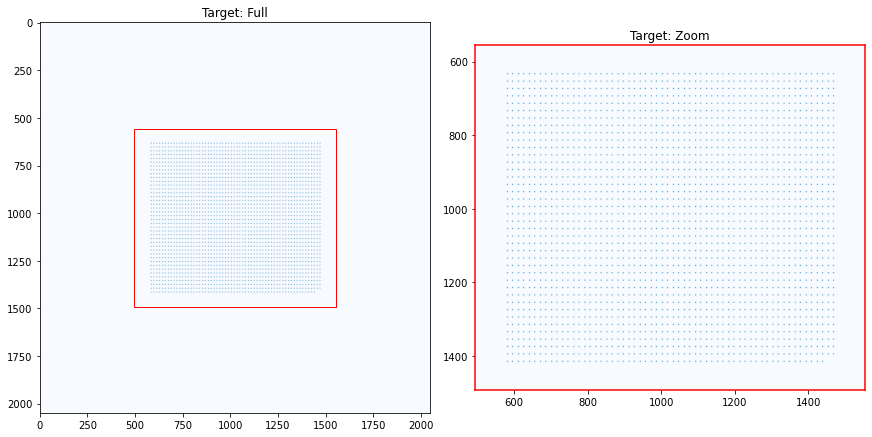

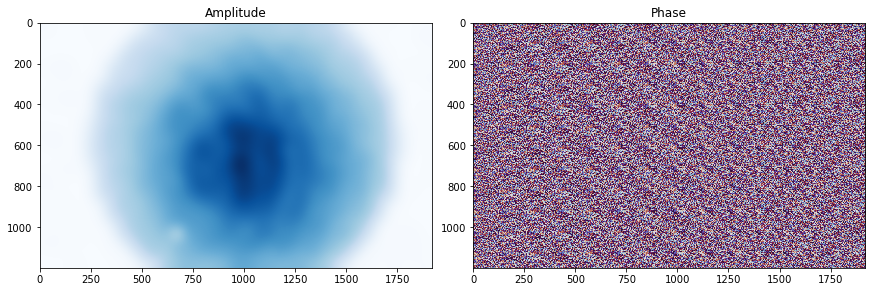

index 1088 is out of bounds for axis 0 with size 1088


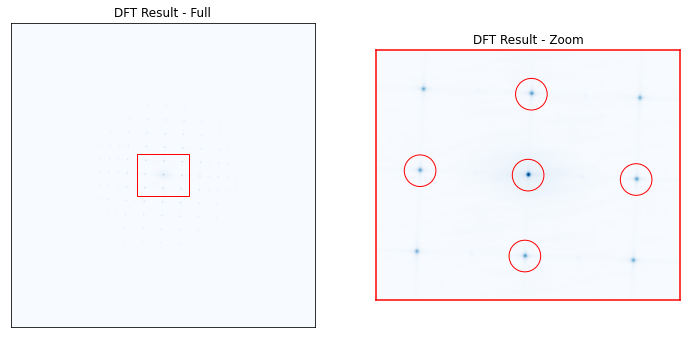

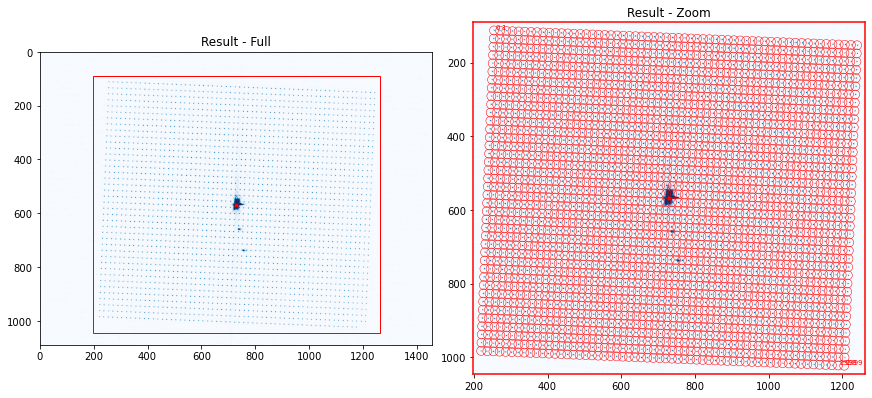

{'M': array([[28837.19627054, -1161.92221443],
       [ 1176.40804064, 28876.92139454]]), 'b': array([[730.],
       [568.]]), 'a': array([[-1.40169603e-05],
       [-1.25669300e-05]])}


In [3]:
cam.set_exposure(5e-2)
result = fs.fourier_calibrate(array_shape=[60, 40], array_pitch=[15, 20], plot=True)
cam.set_exposure(5e-3)
print(result)

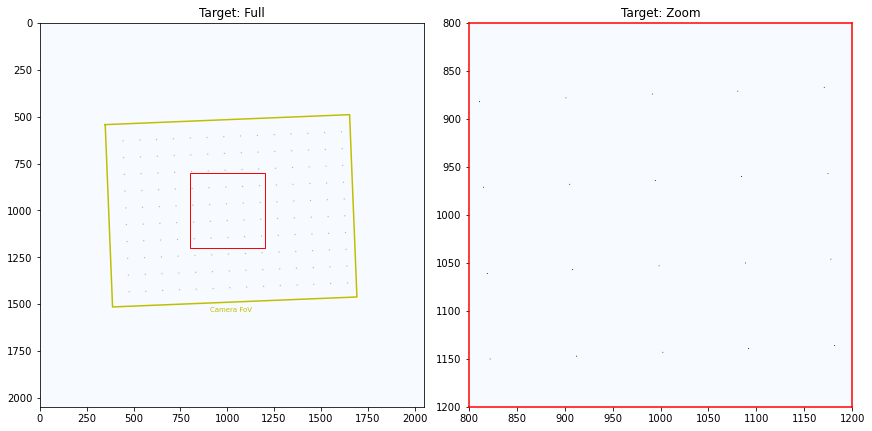

In [4]:
shape = (2048, 2048)
cam_shape = np.array(fs.cam.shape)

xlist = np.arange(100, cam_shape[1], 100)
ylist = np.arange(100, cam_shape[0], 100)

xgrid, ygrid = np.meshgrid(xlist, ylist)

points = np.vstack((xgrid.ravel(), ygrid.ravel()))

hologram = SpotHologram(shape, points, basis='ij', cameraslm=fs)

hologram.plot_farfield(limits=[[800, 1200], [800, 1200]]);

100%|██████████| 50/50 [00:00<00:00, 68.00it/s]


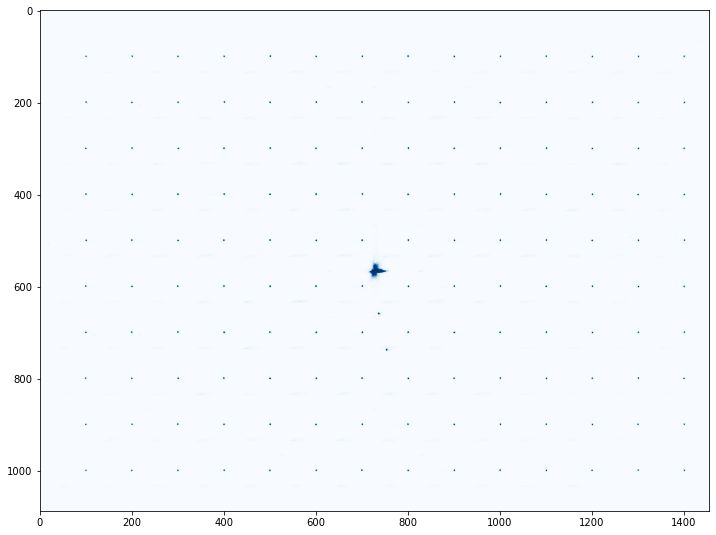

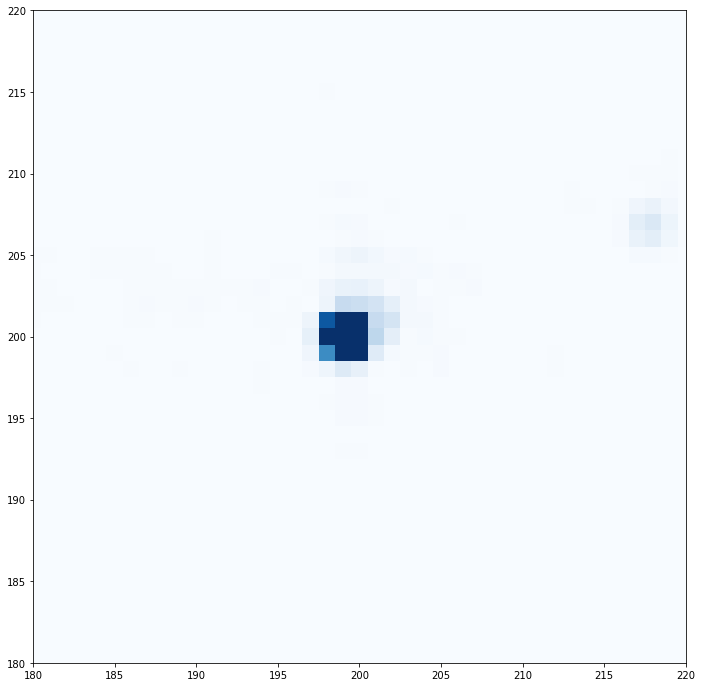

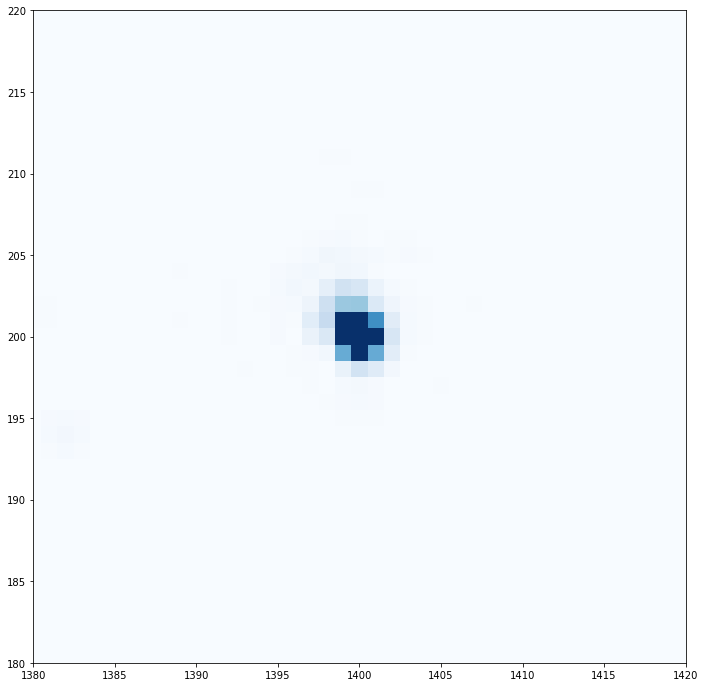

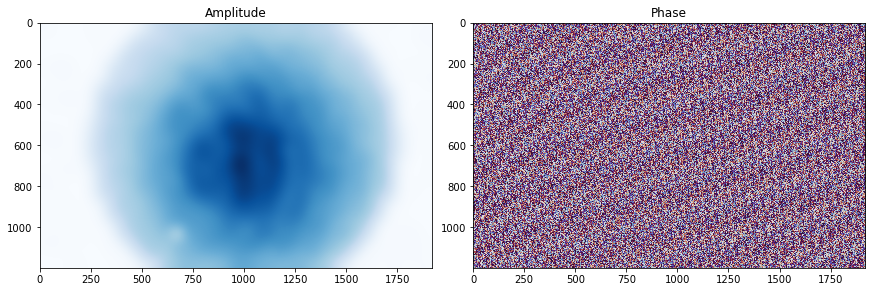

In [5]:
hologram.optimize('WGS-Kim', maxiter=50)

fs.slm.write(hologram.extract_phase(), settle=True)
img = fs.cam.get_image()

plt.figure(figsize=(12,12))
plt.imshow(img)
plt.show()

plt.figure(figsize=(12,12))
plt.imshow(img)
plt.xlim([180, 220])
plt.ylim([180, 220])
plt.show()

plt.figure(figsize=(12,12))
plt.imshow(img)
plt.xlim([1380, 1420])
plt.ylim([180, 220])
plt.show()

hologram.plot_nearfield()

In [6]:
path = os.path.join(os.getcwd(), '../../source/static/qp-slm-small.png')

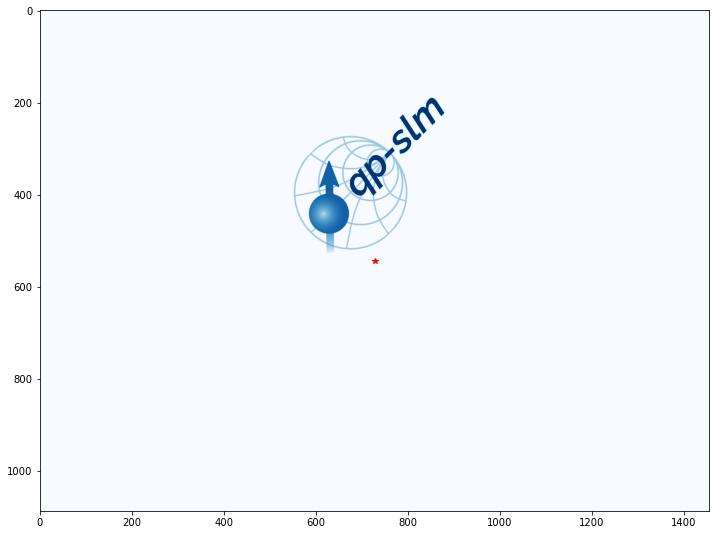

In [7]:
def load_img(path, angle=45, shift=(-200, 0), plot=False):
    # Load the image.
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # This logo has white background, so we invert such that the field is dark, then sqrt for amplitude.
    img_amp = analysis._make_8bit(np.sqrt(cv2.bitwise_not(img)))

    img_amp_rot = ndimage.rotate(img_amp, angle)
    target_ij = toolbox.pad(img_amp_rot, fs.cam.shape)
    target_ij = np.roll(target_ij, shift, axis=(0,1))

    if plot:
        # Plot the desired camera space.
        plt.figure(figsize=(12,12))
        plt.imshow(target_ij)
        plt.plot(target_ij.shape[1]/2, target_ij.shape[0]/2, 'r*')
        plt.show()

    return target_ij

target_ij = load_img(path, plot=True)

Quickly, we'll make some variables to help record and interpret our results:

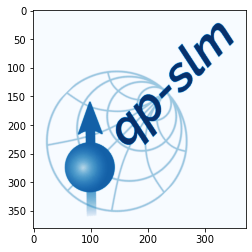

In [8]:
p = 20

# Find the bounds of the non-zero target
sumx = np.where(np.any(target_ij, axis=1))
sumy = np.where(np.any(target_ij, axis=0))

cxi = int(np.amin(sumy) - p)
cxf = int(np.amax(sumy) + p)
cyi = int(np.amin(sumx) - p)
cyf = int(np.amax(sumx) + p)

# Prepare an image dictionary
final_images = {}
final_images["Target"] = target_ij[cyi:cyf, cxi:cxf]

plt.imshow(final_images["Target"])
plt.show()

Now we can look to optimize the SLM phase to produce this desired pattern. Starting without feedback, we try optimization using unweighted GS. Plotted below with our helper function `plot_data` is the result of optimization measured experimentally by our camera, along with the GS weights (See API) that was used during optimization. For unweighted GS, these weights are unchanged from the target, which is just a rotated and stretched version of our desired image.

100%|██████████| 20/20 [00:01<00:00, 16.84it/s]


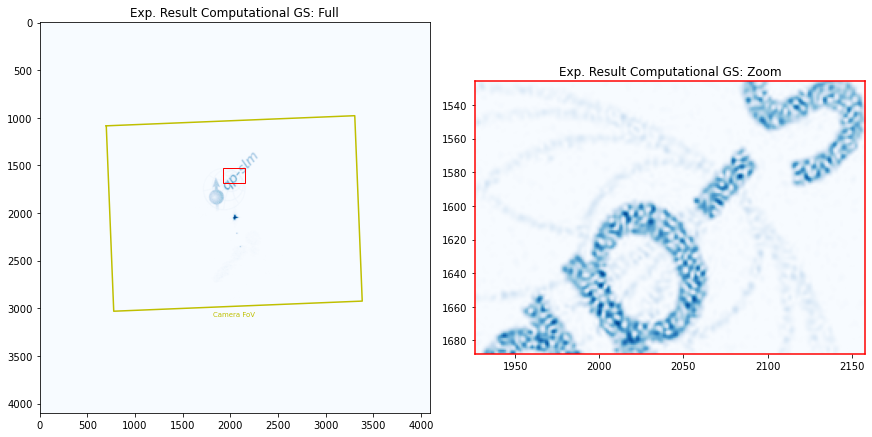

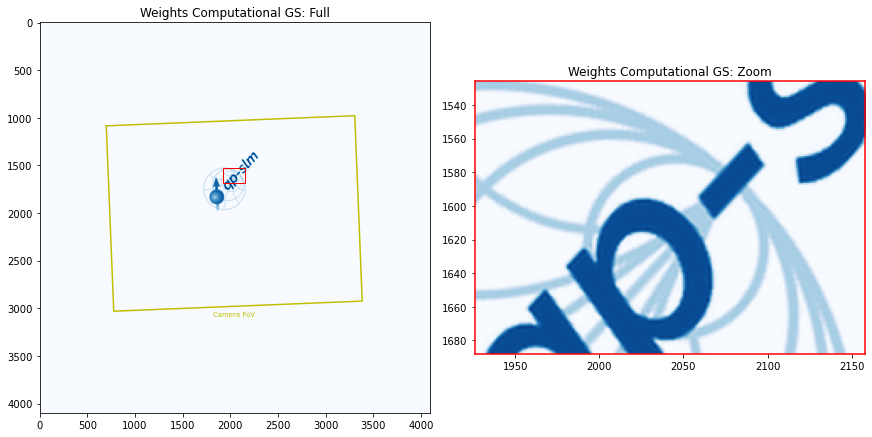

In [9]:
def plot_data(title=' Computational'):
    fs.slm.write(hologram.extract_phase(), settle=True)

    img = fs.cam.get_image()

    limits = [[ 963, 1079], [763, 844]]
    limits = [[ 2*963, 2*1079], [2*763, 2*844]]

    hologram.plot_farfield(hologram.ijcam_to_knmslm(img), limits=limits, title='Exp. Result' + title)
    hologram.plot_farfield(hologram.weights, limits=limits, title='Weights' + title)

shape = (2048, 2048)
shape = (4096, 4096)

hologram = FeedbackHologram(shape=shape, target_ij=target_ij, cameraslm=fs)

hologram.optimize(method="GS", maxiter=20, feedback='computational', stat_groups=['computational'])
plot_data(title=' Computational GS')

img = fs.cam.get_image()
final_images["GS"] = img[cyi:cyf, cxi:cxf]

In [12]:
hologram.flags

{'fixed_phase': False,
 'stat_groups': ['computational'],
 'feedback': 'computational'}

Now if we try weighted GS, we'll see that the weights change according to the internal computational result, but the experimental result isn't too much better.

100%|██████████| 20/20 [00:01<00:00, 16.39it/s]


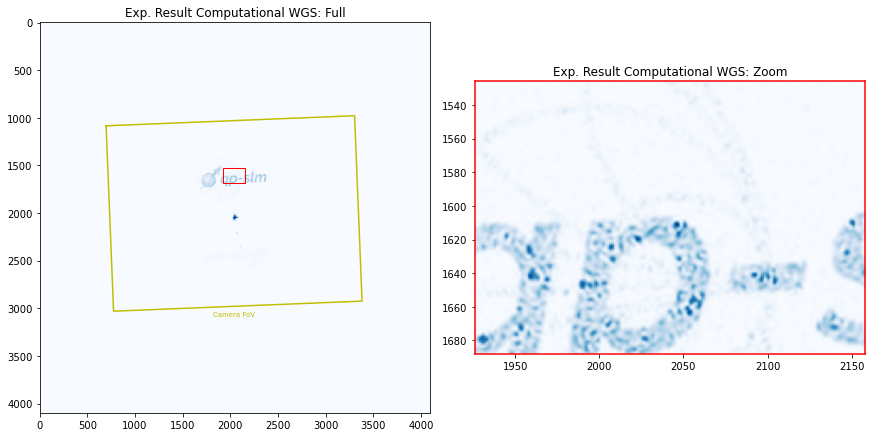

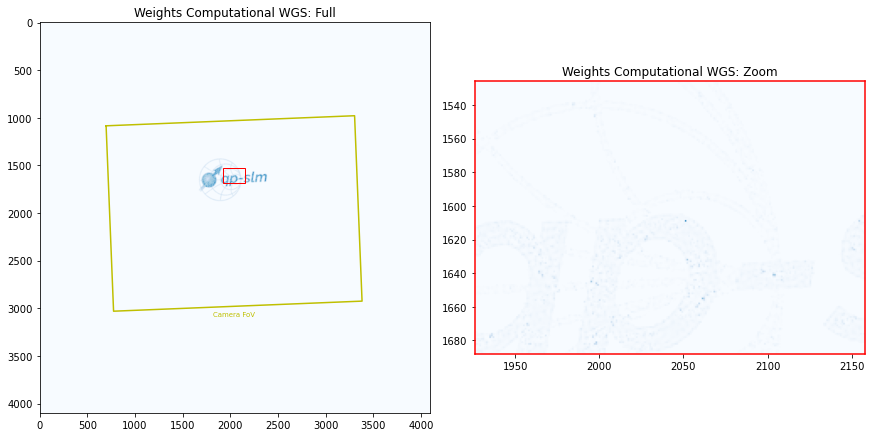

In [37]:
# Renew hologram
hologram = FeedbackHologram(shape=shape, target_ij=target_ij, cameraslm=fs)

# Computational WGS refinement
hologram.optimize(method="WGS-Kim", maxiter=20, feedback='computational', stat_groups=['computational'])
plot_data(title=' Computational WGS')

img = fs.cam.get_image()
final_images["WGS-Computational"] = img[cyi:cyf, cxi:cxf]

In [43]:
toolbox.print_blaze_conversions((0.001, 0), "norm", slm=slm, shape=shape)
print()
toolbox.print_blaze_conversions((0, 0), "norm", slm=slm, shape=shape)

'norm' : (0.001, 0.0)
'kxy' : (0.001, 0.0)
'rad' : (0.001, 0.0)
'knm' : (2099.7661927330173, 2048.0)
'freq' : (0.01263823064770932, 0.0)
'lpmm' : (1.5797788309636651, 0.0)
'mrad' : (1.0, 0.0)
'deg' : (0.05729577951308232, 0.0)

'norm' : (0.0, 0.0)
'kxy' : (0.0, 0.0)
'rad' : (0.0, 0.0)
'knm' : (2048.0, 2048.0)
'freq' : (0.0, 0.0)
'lpmm' : (0.0, 0.0)
'mrad' : (0.0, 0.0)
'deg' : (0.0, 0.0)


With experimental feedback on the weights, however, we observe a clear improvement, where edges become significantly crisper.

100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


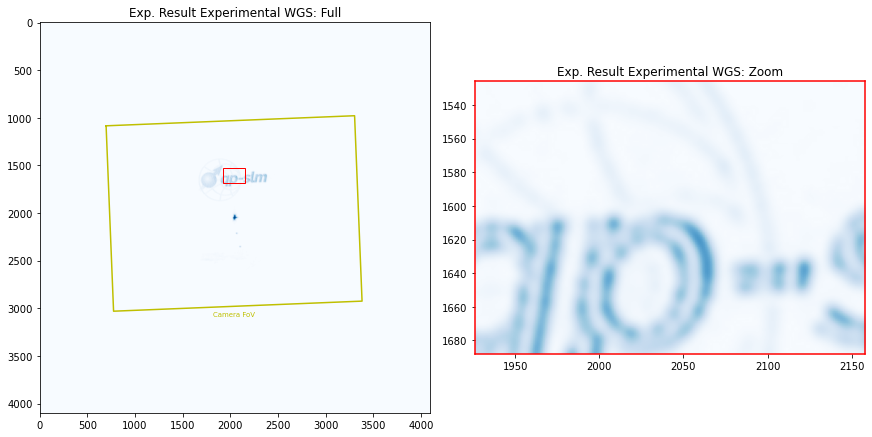

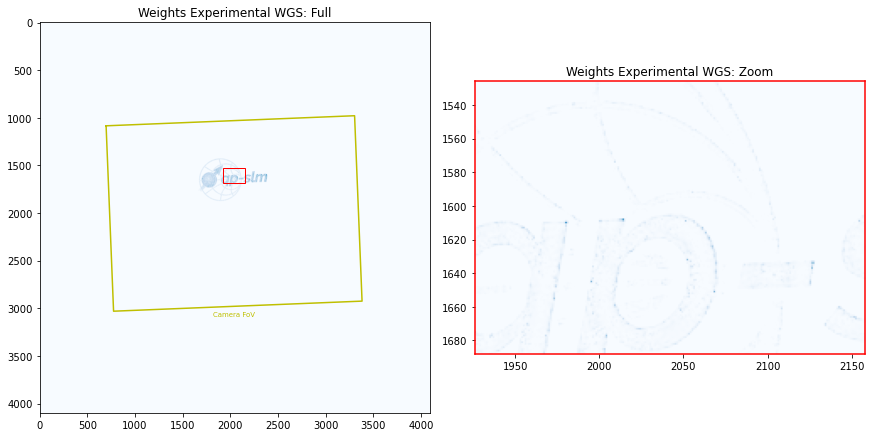

In [38]:
# Experimental WGS refinement
hologram.optimize(  method="WGS-Kim", maxiter=10, feedback='experimental', 
                    stat_groups=['computational', 'experimental'], blur_ij=1)
plot_data(title=' Experimental WGS')

img = fs.cam.get_image()
final_images["WGS-Experimental"] = img[cyi:cyf, cxi:cxf]

We lastly compare the target with these three results to demonstrate the usefulness of Fourier calibration and automated feedback for refining excellent holograms.

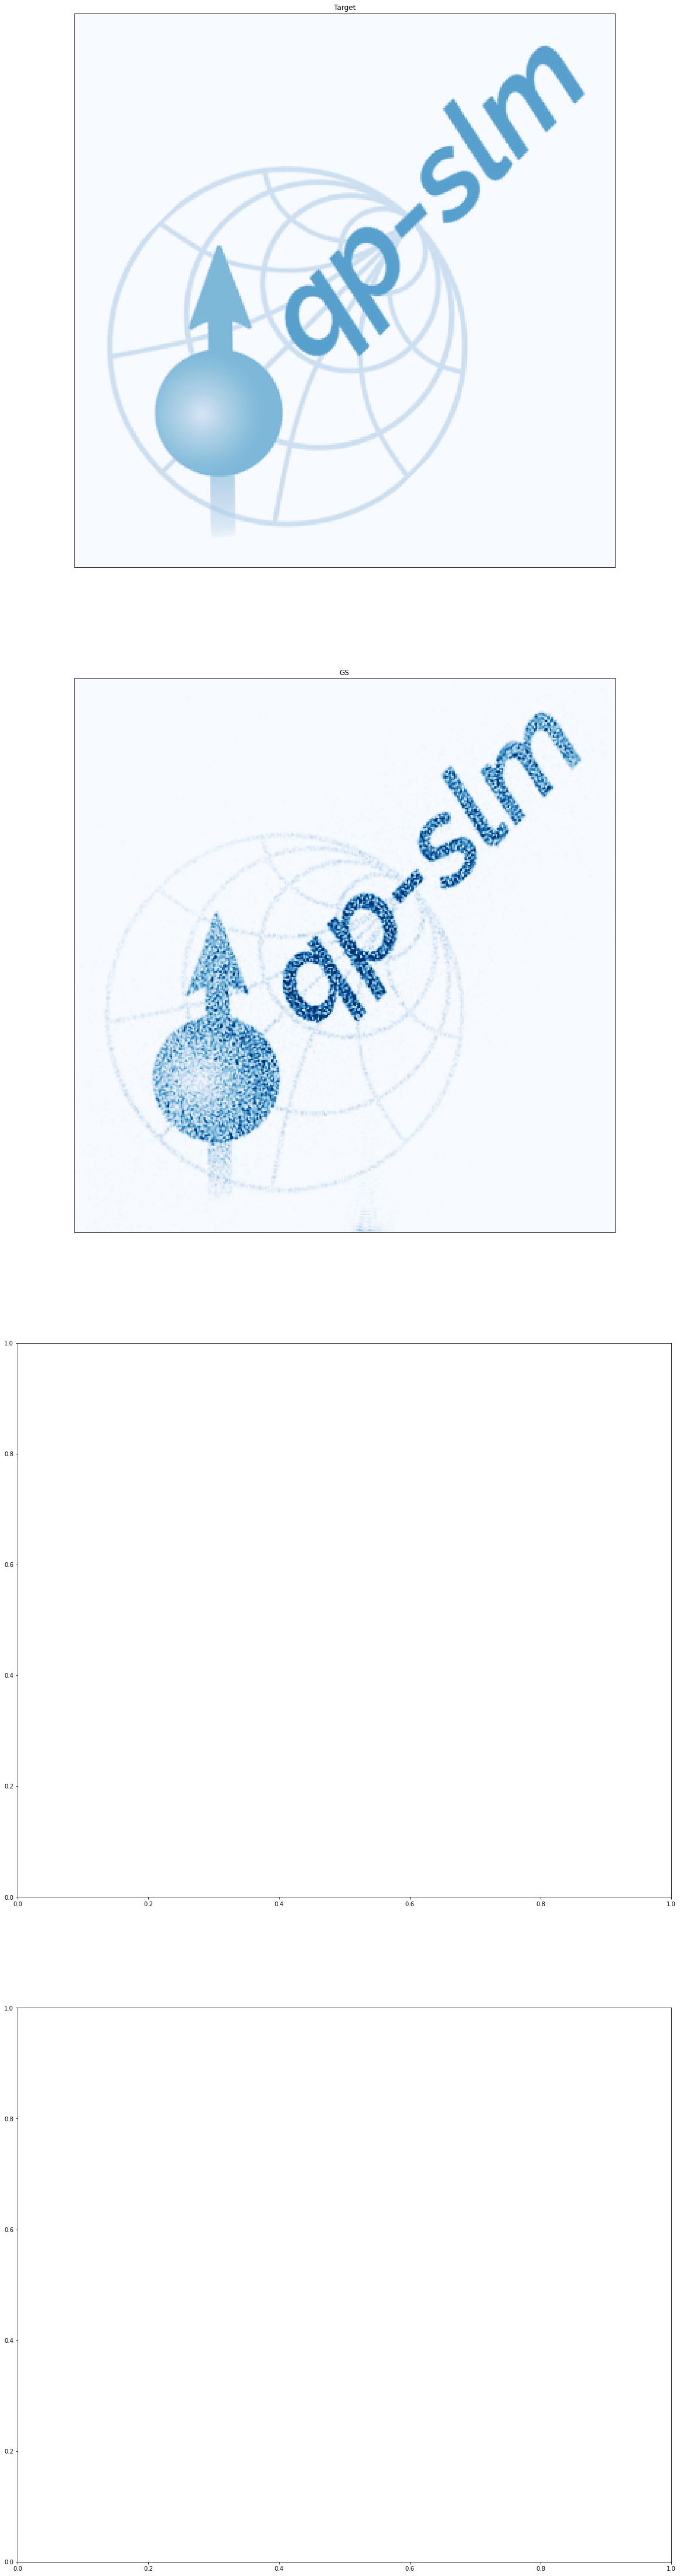

In [16]:
# Get the mean power in all the image such that we can make a more direct comparison.
maxes = []

for x, key in enumerate(final_images.keys()):
    final_images[key] = final_images[key].astype(np.float64)
    final_images[key] *= 1/np.mean(final_images[key])
    maxes.append(np.amax(final_images[key]))

# Choose a clim which slightly saturates the images.
max = np.max(maxes) * .75

# Plot the images.
fig, axs = plt.subplots(4, 1, figsize=(20,80))

for x, key in enumerate(final_images.keys()):
    axs[x].imshow(final_images[key], vmin=0, vmax=max, interpolation="none")
    axs[x].set_title(key)
    axs[x].xaxis.set_visible(False)
    axs[x].yaxis.set_visible(False)